In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
data = pd.read_csv('./train.csv',encoding = 'big5')
print(data.head())

         日期  測站        測項     0     1     2     3     4     5     6  ...  \
0  2014/1/1  豐原  AMB_TEMP    14    14    14    13    12    12    12  ...   
1  2014/1/1  豐原       CH4   1.8   1.8   1.8   1.8   1.8   1.8   1.8  ...   
2  2014/1/1  豐原        CO  0.51  0.41  0.39  0.37  0.35   0.3  0.37  ...   
3  2014/1/1  豐原      NMHC   0.2  0.15  0.13  0.12  0.11  0.06   0.1  ...   
4  2014/1/1  豐原        NO   0.9   0.6   0.5   1.7   1.8   1.5   1.9  ...   

     14    15    16    17    18    19    20    21    22    23  
0    22    22    21    19    17    16    15    15    15    15  
1   1.8   1.8   1.8   1.8   1.8   1.8   1.8   1.8   1.8   1.8  
2  0.37  0.37  0.47  0.69  0.56  0.45  0.38  0.35  0.36  0.32  
3   0.1  0.13  0.14  0.23  0.18  0.12   0.1  0.09   0.1  0.08  
4   2.5   2.2   2.5   2.3   2.1   1.9   1.5   1.6   1.8   1.5  

[5 rows x 27 columns]


In [3]:
# 可以看出前三列没有任何意义，在读取数据时应该删除，并且要把数据中的 ’NR‘ 项设置为0
data = data.iloc[:,3:]
data[data == 'NR'] = 0

raw_data = data.to_numpy()

In [4]:
# 每个月份的数据
# 一天有24个小时的数据，一共有18种数据，一个月只记录20天
month_data = {}

for month in range(12):
    temp = np.empty([18,480])
    for day in range(20):
        # temp 记录的是这一天的24项数据
        # raw_data  18*(20*month + day):18*(20*month+day+1)：表示的是每月每天的18条数据
        temp[:,day*24:(day+1)*24] = raw_data[18*(20*month + day):18*(20*month+day+1),:]
    
    print(temp)
    month_data[month] = temp

[[14.   14.   14.   ... 14.   13.   13.  ]
 [ 1.8   1.8   1.8  ...  1.8   1.8   1.8 ]
 [ 0.51  0.41  0.39 ...  0.34  0.41  0.43]
 ...
 [35.   79.    2.4  ... 48.   63.   53.  ]
 [ 1.4   1.8   1.   ...  1.1   1.9   1.9 ]
 [ 0.5   0.9   0.6  ...  1.2   1.2   1.3 ]]
[[ 15.    14.    14.   ...   8.4    8.     7.6 ]
 [  1.8    1.8    1.7  ...   1.7    1.7    1.7 ]
 [  0.27   0.26   0.25 ...   0.36   0.35   0.32]
 ...
 [113.   109.   104.   ...  72.    65.    69.  ]
 [  2.3    2.2    2.6  ...   1.9    2.9    1.5 ]
 [  2.5    2.2    2.2  ...   0.9    1.6    1.1 ]]
[[ 18.    18.    18.   ...  14.    13.    13.  ]
 [  1.8    1.8    1.8  ...   1.8    1.8    1.8 ]
 [  0.39   0.36   0.4  ...   0.42   0.47   0.49]
 ...
 [103.   128.   115.   ...  60.    94.    53.  ]
 [  1.7    1.4    1.8  ...   4.2    3.5    4.3 ]
 [  1.9    0.8    1.5  ...   3.1    2.4    2.4 ]]
[[ 19.    18.    17.   ...  24.    24.    23.  ]
 [  1.7    1.7    1.7  ...   1.8    1.8    1.9 ]
 [  0.42   0.42   0.42 ...   0.41   0.

In [5]:
# 12个月 乘以  每个月采样471次  为什么是471次？因为前九个小时要做为数据去计算 20*24-9
# 18种数据 乘以 前9个小时的数据
x = np.empty([12*471,18*9],dtype=float)
y = np.empty([12*471,1],dtype=float)

for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14: # 最后一天的时候，最后面是没有y的，滑动窗口会有问题
                continue
            
            x[month*471 + day*24 + hour,:] = month_data[month][:,day*24 + hour : day*24 + hour + 9].reshape(1,-1)
            y[month*471 + day*24 + hour,0] = month_data[month][9,day*24 + hour + 9]

In [6]:
# 对所有的数据进行标准化
mean_x = np.mean(x,axis = 0)
std_x = np.std(x,axis = 0)

for i in range(len(x)):
    for j in range(len(x[0])):
        if std_x[j] != 0:
            x[i][j] = (x[i][j] - mean_x[j]) / std_x[j]

In [7]:
x_train_set = x[:math.floor(len(x) * 0.8),:]
y_train_set = y[:math.floor(len(x) * 0.8),:]

x_validation = x[math.floor(len(x) * 0.8):,:]
y_validation = y[math.floor(len(x) * 0.8):,:]

dim = 18 * 9 + 1 # 加1是为了偏置项
w = np.zeros([dim,1])
# x_train_set = np.concatenate((np.ones([len(x_train_set),1]),x_train_set),axis=1).astype(float)
# x_train_set = np.concatenate((np.ones([x_train_set.shape[0], 1]), x_train_set), axis = 1).astype(float)

In [8]:
learning_rate = 0.1
iter_time = 50000

adagrad = np.zeros([dim,1])
eps = 0.0001
w = np.zeros([dim, 1])
Input = np.concatenate((np.ones([x_train_set.shape[0], 1]), x_train_set), axis=1).astype(float)

for t in range(iter_time):
    # 计算损失
    loss = np.sqrt(np.sum(np.power(np.dot(Input, w) - y_train_set, 2)))

    # 打印损失
    if t % 1000 == 0:
        print(f"迭代次数：{t}   损失值：{loss}")

    # 计算梯度
    gradient = 2 * np.dot(Input.transpose(), np.dot(Input, w) - y_train_set)

    # 更新adagrad
    adagrad += np.power(gradient, 2)

    # 更新权重
    w = w - (learning_rate / np.sqrt(adagrad + eps)) * gradient

# 保存训练后的权重
np.save('./weight.npy', w)

迭代次数：0   损失值：1831.5460682166856
迭代次数：1000   损失值：1134.607165562444
迭代次数：2000   损失值：990.0479643559765
迭代次数：3000   损失值：889.4054043820661
迭代次数：4000   损失值：811.6622613932034
迭代次数：5000   损失值：748.7308326923868
迭代次数：6000   损失值：696.4481175185917
迭代次数：7000   损失值：652.325769328395
迭代次数：8000   损失值：614.7249401355048
迭代次数：9000   损失值：582.4872217798198
迭代次数：10000   损失值：554.7478556705976
迭代次数：11000   损失值：530.832814331352
迭代次数：12000   损失值：510.1985060964785
迭代次数：13000   损失值：492.3947828928523
迭代次数：14000   损失值：477.0413964444932
迭代次数：15000   损失值：463.8125243912636
迭代次数：16000   损失值：452.4262695027806
迭代次数：17000   损失值：442.6372758150663
迭代次数：18000   损失值：434.2313190733497
迭代次数：19000   损失值：427.02115879786714
迭代次数：20000   损失值：420.84320724708164
迭代次数：21000   损失值：415.5547406891653
迭代次数：22000   损失值：411.03148667857033
迭代次数：23000   损失值：407.16548904421177
迭代次数：24000   损失值：403.86319381074543
迭代次数：25000   损失值：401.04372351004173
迭代次数：26000   损失值：398.6373205898978
迭代次数：27000   损失值：396.5839471798928
迭代次数：28000   损失值：394.8320311

In [9]:
# learning_rate = 0.01
# iter_time = 300
# 
# adagrad = np.zeros([dim,1])
# eps = 0.0001
# for t in range(iter_time):
#     loss = np.sqrt(np.sum(np.power(np.dot(x_train_set,w) - y_train_set,2)))
#     
#     if(t%1 == 0):
#         print("迭代次数： %i   损失值： %f"%(t,loss))
#     
#     adagrad = 2 * np.dot(x_train_set.T,np.dot(x_train_set,w) - y_train_set)
#     adagrad += (adagrad ** 2)
#     w = w - learning_rate * adagrad / np.sqrt(adagrad + eps)

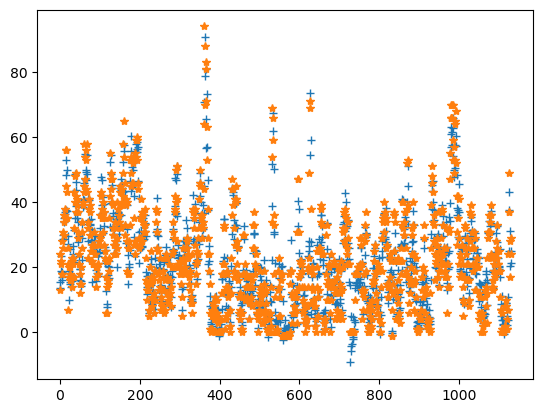

In [10]:
from matplotlib import pyplot as plt
weights = np.load('./weight.npy')

x_axis = np.arange(y_validation.shape[0])
x_validation_input = np.concatenate((np.ones([x_validation.shape[0], 1]), x_validation), axis = 1).astype(float)
y_axis = np.dot(x_validation_input,weights)

plt.plot(x_axis,y_axis,'+')
plt.plot(x_axis,y_validation,'*')
plt.show()

In [11]:
# 假设 y_validation 是实际值，y_axis 是模型预测值
# 计算MSE
mse = np.mean(np.power(y_validation - y_axis, 2))
print('MSE:', mse)

# 计算RMSE
rmse = np.sqrt(mse)
print('RMSE:', rmse)

# 计算R²
# 首先计算总平方和 (SS_tot)
ss_tot = np.sum(np.power(y_validation - np.mean(y_validation), 2))
# 然后计算残差平方和 (SS_res)
ss_res = np.sum(np.power(y_validation - y_axis, 2))
# 最后计算R²
r_squared = 1 - (ss_res / ss_tot)
print('R²:', r_squared)

MSE: 32.08550981438812
RMSE: 5.66440727829383
R²: 0.8653001009947889
